## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)

## Load Data

In [2]:
df = pd.read_csv('data/ClimateDataBasel.csv', header=None)

df.columns = [
    "temp_min", "temp_max", "temp_avg",
    "humidity_min", "humidity_max", "humidity_avg",
    "pressure_min", "pressure_max", "pressure_avg",
    "rain", "snow", "solar", "wind_speed", "wind_dir",
    "visibility", "air_quality", "ozone", "uv_index"
]

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.head()

Dataset shape: (1763, 18)
Missing values: 0


,temp_min,temp_max,temp_avg,humidity_min,humidity_max,humidity_avg,pressure_min,pressure_max,pressure_avg,rain,snow,solar,wind_speed,wind_dir,visibility,air_quality,ozone,uv_index
0,8.100529,17.570530,13.445111,61,96,77.875000,1013.1,1018.4,1015.75830,0.2,0.0,350.56274,3.240000,23.400000,12.210002,1.787066,10.403253,6.639939
1,11.110529,18.490528,14.988861,59,94,76.458336,1013.9,1016.6,1014.99170,1.9,0.0,287.23404,6.479999,25.199999,14.880001,4.161301,16.285300,8.616541
2,10.320529,18.170528,14.267612,71,96,83.583336,1015.3,1017.5,1016.38745,0.1,0.0,126.26506,3.240000,24.119999,12.764999,2.028842,11.289829,6.372418
3,10.450529,24.980530,17.309278,54,92,77.625000,1015.9,1018.7,1017.26250,0.0,0.0,881.24710,2.160000,20.160000,9.480000,0.799200,11.483046,4.690738
4,12.350529,25.610529,19.881780,47,88,66.583336,1015.7,1020.7,1018.18353,0.0,0.0,951.56665,0.720000,15.840000,5.565001,0.376746,6.443357,3.311275


## Feature Engineering

In [3]:
# Create range features
df['temp_range'] = df['temp_max'] - df['temp_min']
df['humidity_range'] = df['humidity_max'] - df['humidity_min']
df['pressure_range'] = df['pressure_max'] - df['pressure_min']

# Drop redundant min/max columns
df_clean = df.drop(columns=[
    'temp_min', 'temp_max',
    'humidity_min', 'humidity_max',
    'pressure_min', 'pressure_max'
])

print(f"Features after engineering: {df_clean.shape[1]}")
print(df_clean.columns.tolist())

Features after engineering: 15
['temp_avg', 'humidity_avg', 'pressure_avg', 'rain', 'snow', 'solar', 'wind_speed', 'wind_dir', 'visibility', 'air_quality', 'ozone', 'uv_index', 'temp_range', 'humidity_range', 'pressure_range']


## Preprocessing - Standard Scaling

In [4]:
# Use StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
df_scaled = pd.DataFrame(X_scaled, columns=df_clean.columns)

print("Scaled data statistics:")
print(df_scaled.describe())

Scaled data statistics:
           temp_avg  humidity_avg  pressure_avg          rain         snow  \
count  1.763000e+03  1.763000e+03  1.763000e+03  1.763000e+03  1763.000000   
mean   9.672732e-17  8.141216e-16  4.824275e-15  3.627274e-17     0.000000   
std    1.000284e+00  1.000284e+00  1.000284e+00  1.000284e+00     1.000284   
min   -2.315664e+00 -3.267666e+00 -4.725439e+00 -4.299240e-01    -0.132379   
25%   -9.137280e-01 -7.512659e-01 -5.245193e-01 -4.299240e-01    -0.132379   
50%    2.163763e-01  9.585963e-02 -7.516383e-02 -4.299240e-01    -0.132379   
75%    8.781015e-01  7.702299e-01  5.053186e-01 -8.664681e-02    -0.132379   
max    2.015438e+00  2.418691e+00  3.565168e+00  1.026888e+01    26.843682   

              solar    wind_speed      wind_dir    visibility   air_quality  \
count  1.763000e+03  1.763000e+03  1.763000e+03  1.763000e+03  1.763000e+03   
mean   5.642427e-17 -4.836366e-17 -2.256971e-16  4.030305e-18 -1.894243e-16   
std    1.000284e+00  1.000284e+00  1

## Correlation Analysis

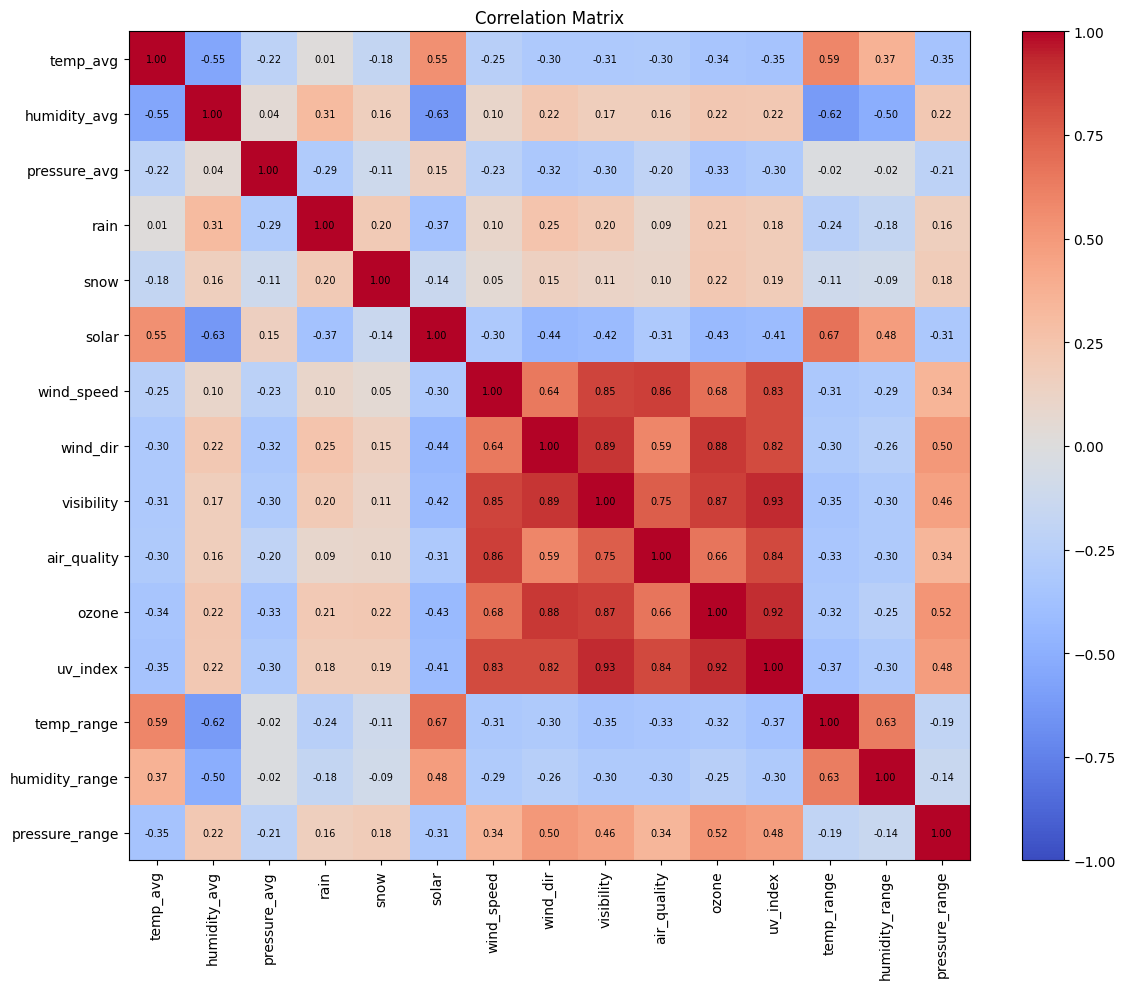

In [13]:
corr_matrix = df_scaled.corr()

plt.figure(figsize=(12, 10))
im = plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Annotate with values
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=7)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Dimensionality Reduction - PCA

Original features: 15
PCA components: 10
Explained variance: 0.9593

Variance per component: [0.43206547 0.16182542 0.09274196 0.06852687 0.05403164 0.04040032
 0.03524209 0.03180533 0.02403934 0.01861483]


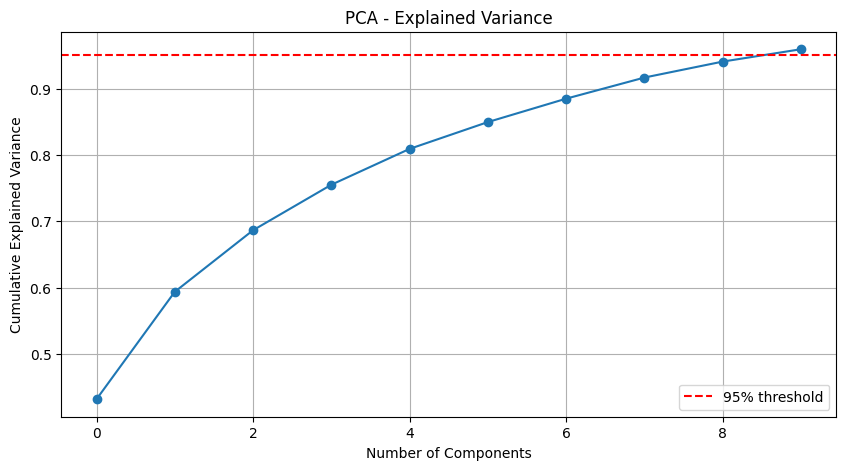

In [5]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA components: {pca.n_components_}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")
print(f"\nVariance per component: {pca.explained_variance_ratio_}")

# Cumulative variance plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.legend()
plt.show()

# Create PCA dataframe
pc_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)

## KMeans Clustering with K=3

In [6]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=1000)
labels_kmeans = kmeans.fit_predict(X_pca)

# Metrics
sil_kmeans = silhouette_score(X_pca, labels_kmeans)
db_kmeans = davies_bouldin_score(X_pca, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X_pca, labels_kmeans)

print(f"\n=== KMeans (k={k}) with StandardScaler ===")
print(f"Silhouette Score: {sil_kmeans:.4f}")
print(f"Davies-Bouldin Index: {db_kmeans:.4f}")
print(f"Calinski-Harabasz Score: {ch_kmeans:.4f}")
print(f"\nCluster sizes: {np.bincount(labels_kmeans)}")


=== KMeans (k=3) with StandardScaler ===
Silhouette Score: 0.2472
Davies-Bouldin Index: 1.3904
Calinski-Harabasz Score: 665.2102

Cluster sizes: [801 257 705]


## Visualize KMeans K=3

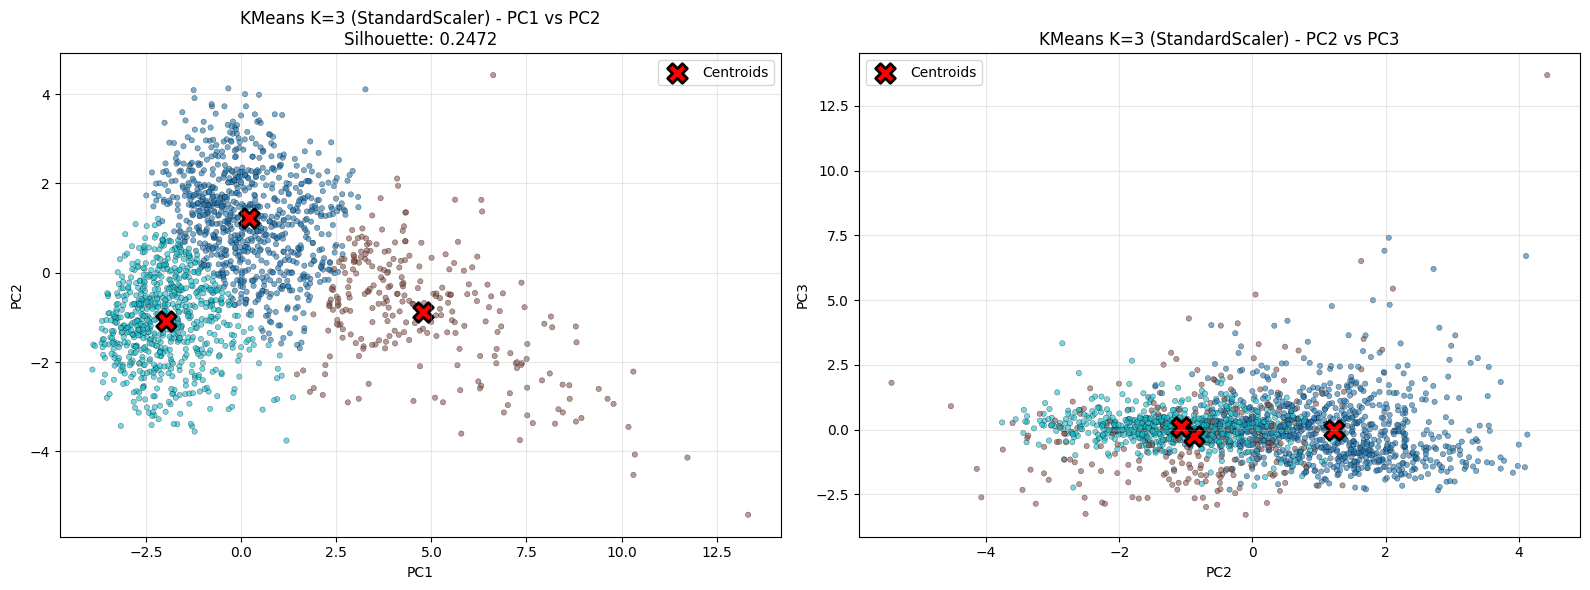

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1 vs PC2
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, 
                          cmap='tab10', s=15, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[0].scatter(kmeans.cluster_centers_[:, 0], 
                kmeans.cluster_centers_[:, 1],
                c='red', s=200, marker='X', edgecolors='black', linewidth=2, label='Centroids')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'KMeans K=3 (StandardScaler) - PC1 vs PC2\nSilhouette: {sil_kmeans:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PC2 vs PC3 (if available)
if X_pca.shape[1] >= 3:
    axes[1].scatter(X_pca[:, 1], X_pca[:, 2], c=labels_kmeans, 
                    cmap='tab10', s=15, alpha=0.6, edgecolors='k', linewidth=0.3)
    axes[1].scatter(kmeans.cluster_centers_[:, 1], 
                    kmeans.cluster_centers_[:, 2],
                    c='red', s=200, marker='X', edgecolors='black', linewidth=2, label='Centroids')
    axes[1].set_xlabel('PC2')
    axes[1].set_ylabel('PC3')
    axes[1].set_title(f'KMeans K=3 (StandardScaler) - PC2 vs PC3')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compare K Values (2-7)

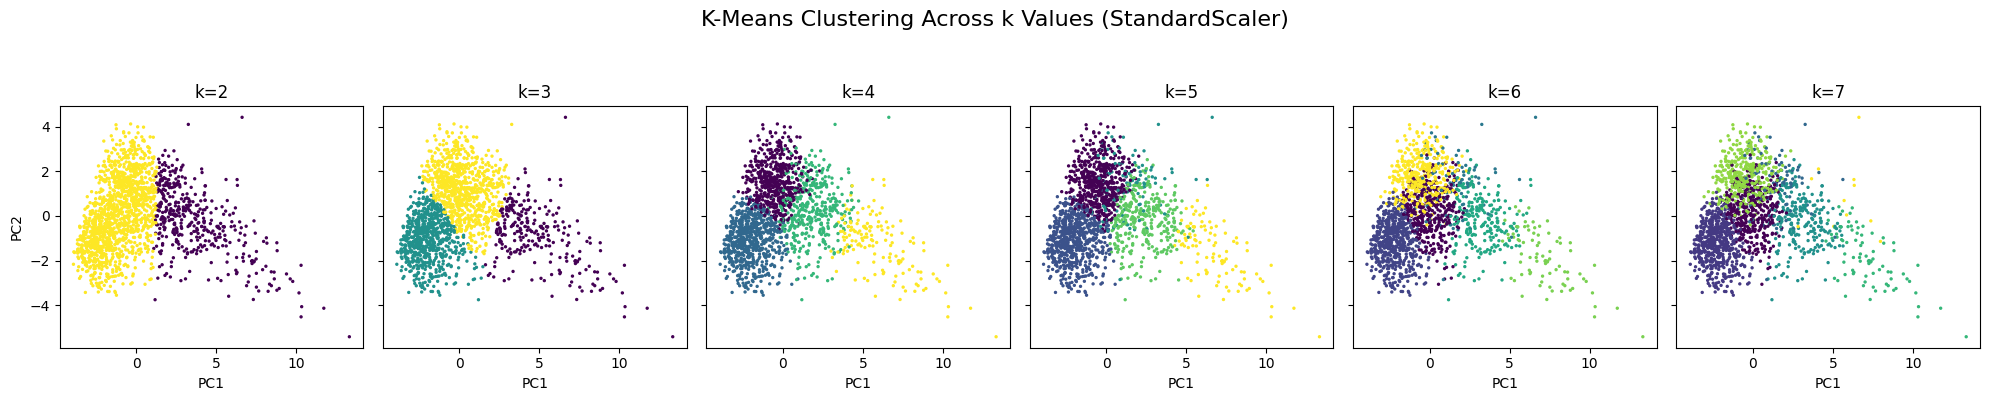

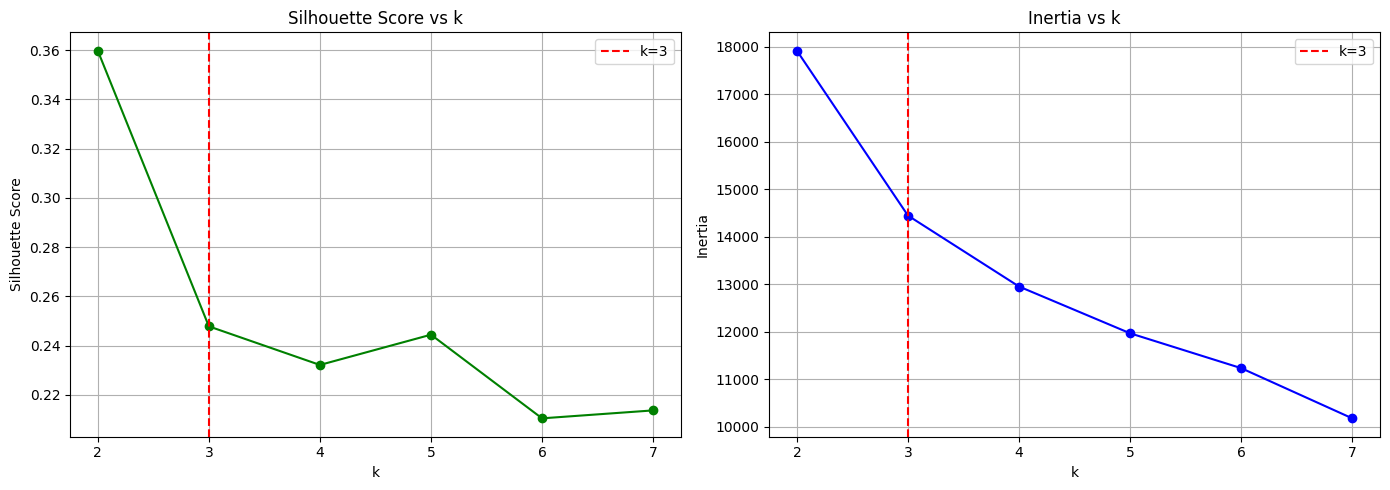


Silhouette scores: {2: '0.3598', 3: '0.2478', 4: '0.2322', 5: '0.2444', 6: '0.2105', 7: '0.2137'}


In [8]:
k_values = [2, 3, 4, 5, 6, 7]
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

fig, axes = plt.subplots(1, len(k_values), figsize=(20, 4), sharex=True, sharey=True)
plt.suptitle('K-Means Clustering Across k Values (StandardScaler)', fontsize=16, y=1.02)

silhouette_scores = []
inertia_values = []

for j, k in enumerate(k_values):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    ax = axes[j]
    scatter = ax.scatter(pc1, pc2, c=labels, cmap='viridis', s=2, alpha=1)
    ax.set_title(f'k={k}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.label_outer()
    
    # calculate silhouette score and inertia
    silhouette_scores.append(silhouette_score(X_pca, labels))
    inertia_values.append(km.inertia_)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Plot metrics
fig2, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(k_values, silhouette_scores, marker='o', color='green')
ax[0].set_title('Silhouette Score vs k')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Silhouette Score')
ax[0].grid(True)
ax[0].axvline(3, color='r', linestyle='--', label='k=3')
ax[0].legend()

ax[1].plot(k_values, inertia_values, marker='o', color='blue')
ax[1].set_title('Inertia vs k')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].grid(True)
ax[1].axvline(3, color='r', linestyle='--', label='k=3')
ax[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSilhouette scores: {dict(zip(k_values, [f'{s:.4f}' for s in silhouette_scores]))}")

## Agglomerative Clustering K=3

In [ ]:
# Test different linkage methods with k=3
linkage_methods = ['ward', 'complete', 'average']
best_agg_score = -1
best_agg_params = None

print("\nTesting Agglomerative Clustering (k=3):")
for linkage_method in linkage_methods:
    agg = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    labels_agg = agg.fit_predict(X_pca)
    
    sil = silhouette_score(X_pca, labels_agg)
    db = davies_bouldin_score(X_pca, labels_agg)
    
    print(f"Linkage={linkage_method}: silhouette={sil:.4f}, DB={db:.4f}")
    
    if sil > best_agg_score:
        best_agg_score = sil
        best_agg_params = {'linkage': linkage_method, 'labels': labels_agg, 'sil': sil, 'db': db}

print(f"\nBest Agglomerative: {best_agg_params['linkage']}, silhouette={best_agg_params['sil']:.4f}")


Testing Agglomerative Clustering (k=3):
Linkage=ward: silhouette=0.2064, DB=1.3237
Linkage=complete: silhouette=0.5386, DB=0.4822
Linkage=average: silhouette=0.5662, DB=0.6343

Best Agglomerative: average, silhouette=0.5662


## Side-by-Side Comparison

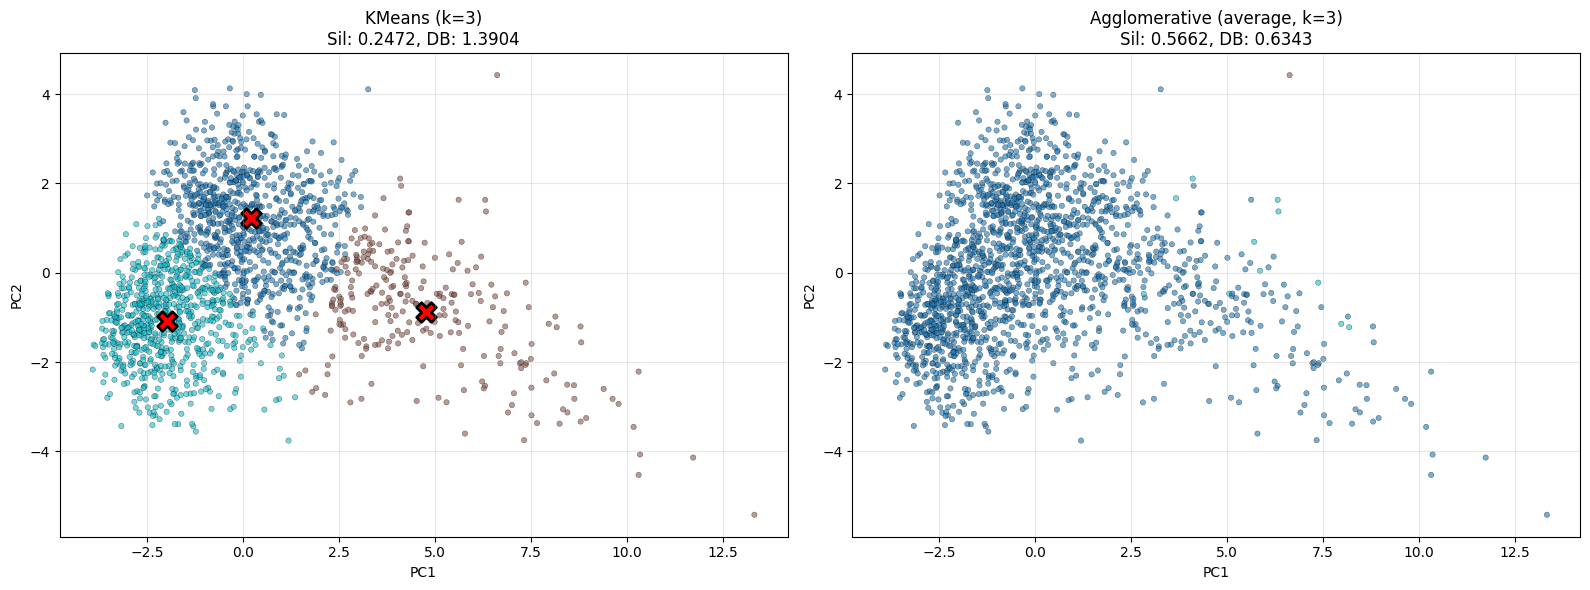

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KMeans K=3
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, 
                cmap='tab10', s=15, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[0].scatter(kmeans.cluster_centers_[:, 0], 
                kmeans.cluster_centers_[:, 1],
                c='red', s=200, marker='X', edgecolors='black', linewidth=2)
axes[0].set_title(f'KMeans (k=3)\nSil: {sil_kmeans:.4f}, DB: {db_kmeans:.4f}')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True, alpha=0.3)

# Agglomerative
if best_agg_params:
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=best_agg_params['labels'], 
                    cmap='tab10', s=15, alpha=0.6, edgecolors='k', linewidth=0.3)
    axes[1].set_title(f'Agglomerative ({best_agg_params["linkage"]}, k=3)\nSil: {best_agg_params["sil"]:.4f}, DB: {best_agg_params["db"]:.4f}')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## UMAP Visualization

Computing UMAP embedding...


/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


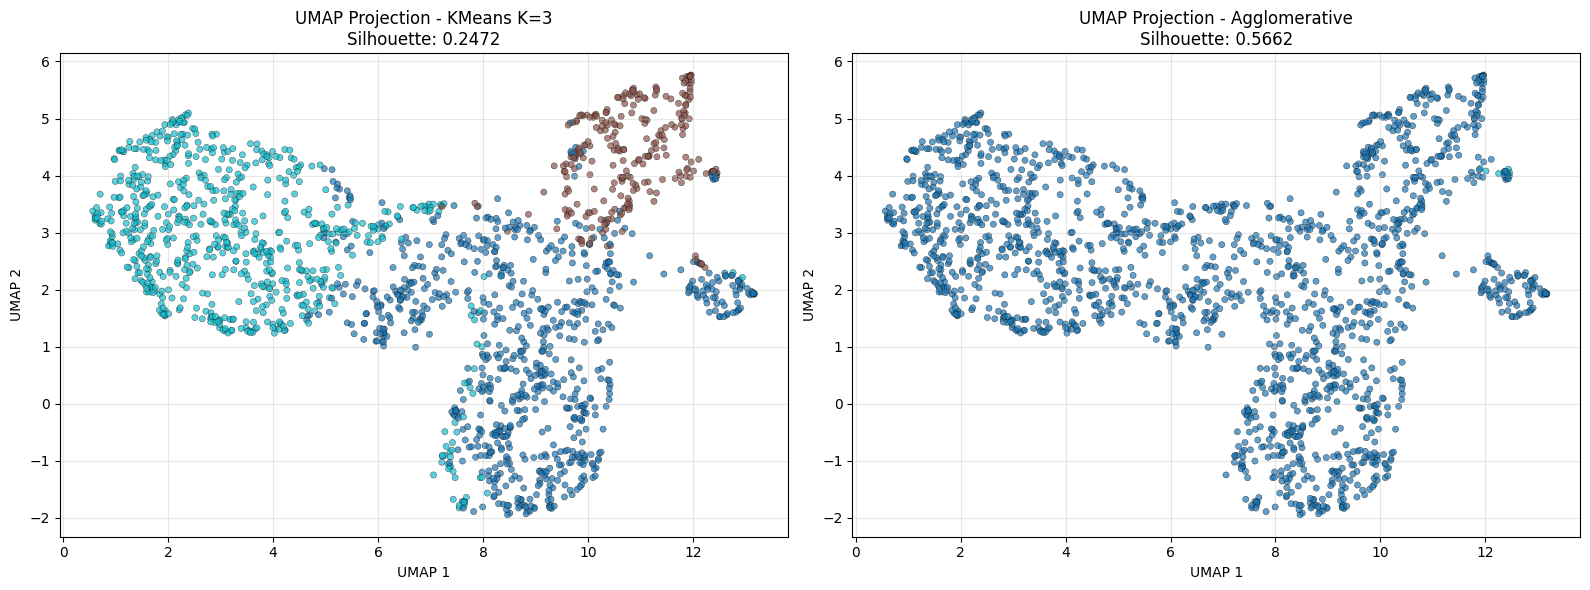

In [11]:
# UMAP for better 2D visualization
print("Computing UMAP embedding...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_pca)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# UMAP with KMeans labels
axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=labels_kmeans, 
                cmap='tab10', s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0].set_title(f'UMAP Projection - KMeans K=3\nSilhouette: {sil_kmeans:.4f}')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].grid(True, alpha=0.3)

# UMAP with Agglomerative labels
if best_agg_params:
    axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=best_agg_params['labels'], 
                    cmap='tab10', s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
    axes[1].set_title(f'UMAP Projection - Agglomerative\nSilhouette: {best_agg_params["sil"]:.4f}')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cluster Characteristics

In [12]:
# Add cluster labels to original dataframe
df_analysis = df_clean.copy()
df_analysis['cluster'] = labels_kmeans

# Show cluster statistics
print("\nCluster Characteristics (K=3, StandardScaler):")
print("="*80)
for cluster_id in range(3):
    cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    print(cluster_data.describe().T[['mean', 'std']].round(2))
    print("-" * 80)


Cluster Characteristics (K=3, StandardScaler):

Cluster 0 (n=801):
                   mean     std
temp_avg           8.05    7.14
humidity_avg      77.02    7.26
pressure_avg    1019.48    9.42
rain               2.16    4.44
snow               0.05    0.24
solar            244.03  196.42
wind_speed         5.39    4.12
wind_dir          28.71   11.76
visibility        15.58    6.65
air_quality        2.30    1.78
ozone             13.79    5.12
uv_index           7.53    2.88
temp_range         6.29    1.92
humidity_range    29.29    9.49
pressure_range     5.59    2.99
cluster            0.00    0.00
--------------------------------------------------------------------------------

Cluster 1 (n=257):
                   mean     std
temp_avg           5.95    4.70
humidity_avg      75.05    7.75
pressure_avg    1012.32    9.85
rain               2.49    3.53
snow               0.32    1.25
solar            161.94  178.52
wind_speed        21.65   11.49
wind_dir          58.63   15.05